In [1]:
# for memory error >> try to change the float 64 to float 32 
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
#from scipy.signal import freqz
from scipy.signal import butter,lfilter,filtfilt
#from scipy.interpolate import interp1d
#from __future__ import division, print_function
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats

def upload_mat (filename):
    Data= sio.loadmat(filename)
    skips=[ '__header__','__globals__','__version__']
    for k in Data.keys():
        if k in skips:
            Data.pop(k,None)
        else:
            Data[k]=pd.DataFrame(Data[k])
    return (Data)



#search on Hampel filter to remove spikes. and make notch filter on 50 hz
def filteration (data,sample_rate=2000.0,cut_off=20.0,order=5,ftype='highpass'): 
    nyq = .5 * sample_rate
    b,a=butter(order,cut_off/nyq,btype=ftype)
    d= lfilter(b,a,data,axis=0)
    return pd.DataFrame(d)

 
def mean_std_normalization (df):
    m = df.mean(axis=0)
    s =df.std(axis=0)
    normalized_df =df/m
    return m,s,normalized_df


def prepare_df(rep,normalized_emg):
    df=normalized_emg.loc[rep]
    df=df.reset_index()  
    LL=df['label']
    df=df.drop(['rep','label'],1)
    
    return df,LL

def MES_analysis_window (df,width,tau,win_num):
    df_2=pd.DataFrame()
    start= win_num*tau
    end= start+width
    df_2=df.iloc[start:end]
    return end,df_2

def features_extraction (df,th=0):
    #F1 : mean absolute value (MAV)
    MAV=abs(df.mean(axis=0)) 
    
    MAV=list(MAV)
    WL = []
    SSC= []
    ZC = []
    for col,series in df.iteritems():
        #F2 : wave length (WL)
        s=abs(np.array(series.iloc[:-1])- np.array(series.iloc[1:]))
        WL_result=np.sum(s)
        WL.append( WL_result)
        
        #F3 : zero crossing(ZC)
        _1starray=np.array(series.iloc[:-1])
        _2ndarray=np.array(series.iloc[1:])
        ZC.append(((_1starray*_2ndarray<0) & (abs(_1starray - _2ndarray)>=th) ).sum())
        
        
         #F4 : slope sign change(SSC)
        _1st=np.array(series.iloc[:-2])
        _2nd=np.array(series.iloc[1:-1])
        _3rd=np.array(series.iloc[2:])
        SSC.append(((((_2nd - _1st)*(_2nd - _3rd))>0) &(((abs(_2nd - _1st))>=th) | ((abs(_2nd - _3rd))>=th))).sum())
    
    features_array=np.array([MAV,WL,ZC,SSC]).T
    return features_array

def get_predictors_and_outcomes(intended_movement_labels,rep,emg,label_series,width=512,tau=512):
    x=[];y=[];
    end=0; win_num=0; 
    while((len(emg)-end) >= width):
        end,window_df=MES_analysis_window(emg,width,tau,win_num)
        win_num=win_num + 1
        
        ff=features_extraction(window_df)
        x.append(ff)
        
        expected_labels=label_series.iloc[win_num*tau: ((win_num*tau)+width)]
        mode,count=stats.mode(expected_labels)
        y.append(mode)
        
    predictors_array=np.array(x)
    outcomes_array=np.array(y)

    nsamples, nx, ny = predictors_array.shape
    predictors_array_2d = predictors_array.reshape((nsamples,nx*ny))

    return predictors_array_2d,outcomes_array


def visualization_decesions(labels_online_total):
    C_y_axis=labels_online_total
    C_x_axis=range(len(labels_online_total))
    plt.plot(C_x_axis,C_y_axis,'.k')
    plt.show()
   
def visualization_all_ch (df,zooming_from_to,fs=2000): #439 not fixed  : df.shape[0]/fs

    x=np.linspace(0,np.ceil(df.shape[0])/fs,df.shape[0]) #the time using sampling freq
    f, ax = plt.subplots(12, sharex=True,figsize=(25,25))
    for i in range(12):
        y = df.iloc[:,i]
        ax[i].plot(x,y)
        
    # Fine-tune figure; make subplots close to each other and hide x ticks for all but bottom plot.
    f.subplots_adjust(hspace=0)
    #plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.xlim(zooming_from_to)
    plt.grid(True)
    plt.show()
    

    
    
def visualization_one_ch (df,ch_num,zooming_from_to,fs=2000):

        x=np.linspace(0,np.ceil(df.shape[0])/fs,df.shape[0]) #the time using sampling freq
        y=df.iloc[:,ch_num]#rows value in the intended electrode number
        plt.plot(x,y)
        plt.xlim(zooming_from_to)
        plt.grid(True)
        plt.show()
        


In [2]:
filename =  "C:\Users\Public\Documents\S1_E1_A1"  #change the subject S1,S2,S3 .. 
Data=upload_mat(filename)


In [3]:
emg_df=Data['emg']
stimulus_df=Data["stimulus"]
rep_df=Data['repetition']

emg_df["label"]=stimulus_df
emg_df["rep"] =rep_df

emg_df=emg_df.set_index("label")
#intended_movement_labels=np.random.randint(1,18,size=5)
intended_movement_labels=[1,3,10,11,15] 
#intended_movement_labels=[6,16,17,13,14] #62% acc
#intended_movement_labels=[6,5,15,17,1]  #acc 75% at k=5.. acc 73% at k=7
emg_df=emg_df.loc[intended_movement_labels]
emg_df=emg_df.reset_index()  

updated_label=emg_df['label']
updated_rep=emg_df['rep']
emg_df=emg_df.drop(['label','rep'],1)
#emg_df

In [4]:
filtered_emg=filteration (emg_df)
mean,std,normalized_emg=mean_std_normalization (filtered_emg)
#normalized_emg=filteration (emg_df)

normalized_emg['label']=updated_label
normalized_emg['rep']=updated_rep

normalized_emg=normalized_emg.set_index('rep')

In [5]:
#the classifier, train part
rep_train=[1,3,6,4]
normalized_emg_train,LL_train=prepare_df(rep_train,normalized_emg)

predictors_train,outcomes_train=get_predictors_and_outcomes(intended_movement_labels,rep_train,normalized_emg_train,LL_train)
knn=KNeighborsClassifier(n_neighbors=5) #try k=7 ,k=5
knn.fit(predictors_train,outcomes_train)



C:\Users\m\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [6]:
#Accuracy of the test data
rep_test=[2,5]
normalized_emg_test,LL_test=prepare_df(rep_test,normalized_emg)
predictors_test,outcomes_test=get_predictors_and_outcomes(intended_movement_labels,rep_test,normalized_emg_test,LL_test)
accuracy_test=knn.score(predictors_test,outcomes_test)*100
accuracy_test

81.308411214953267

In [7]:
#test online part
#inside the while, i expect four main funcs. 1)windowing MES ..  2)extract features .. 3)classifier .. 4)post proc
width=512; tau=512 ; end=0; win_num=0; labels_online_total=[]; outcomes_online=[];
rep_online=[2,5]
normalized_emg_online,LL_online=prepare_df(rep_online,normalized_emg)

while((len(normalized_emg_online)-end) >= width):
    
    # first func. : Windowing MES
    end,window_df=MES_analysis_window(normalized_emg_online,width,tau,win_num)
    win_num=win_num + 1
    
    #second func. : extract features
    test_features_array=features_extraction(window_df)
    test_features_array=test_features_array.reshape(1,-1)
    
    
    #third func. : classifer and getting the decesion
    label_online=knn.predict(test_features_array)
    labels_online_total.append(label_online)
    mode,count=stats.mode(LL_online.iloc[win_num*tau: ((win_num*tau)+width)])
    outcomes_online.append(mode)
    
    #forth func. : post processing (majority vote for the result)
    

    


    
#to see is the post processing affect the accuracy or not?   
accuracy_online=np.mean((np.array(labels_online_total)==np.array(outcomes_online)))*100
accuracy_online

81.308411214953267

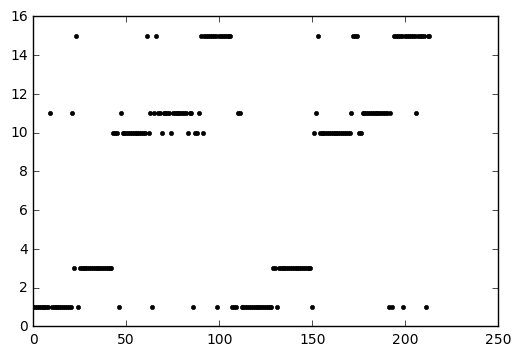

In [8]:
visualization_decesions(labels_online_total)

In [175]:
#Post processing trail 
#for i in range(0,len(labels_online_total),10):
#    mode,count=stats.mode(labels_online_total[i:i+10])
#    labels_online_total[i:i+10]=9*[mode]
#np.mean((np.array(labels_online_total)==np.array(outcomes_online)))*100

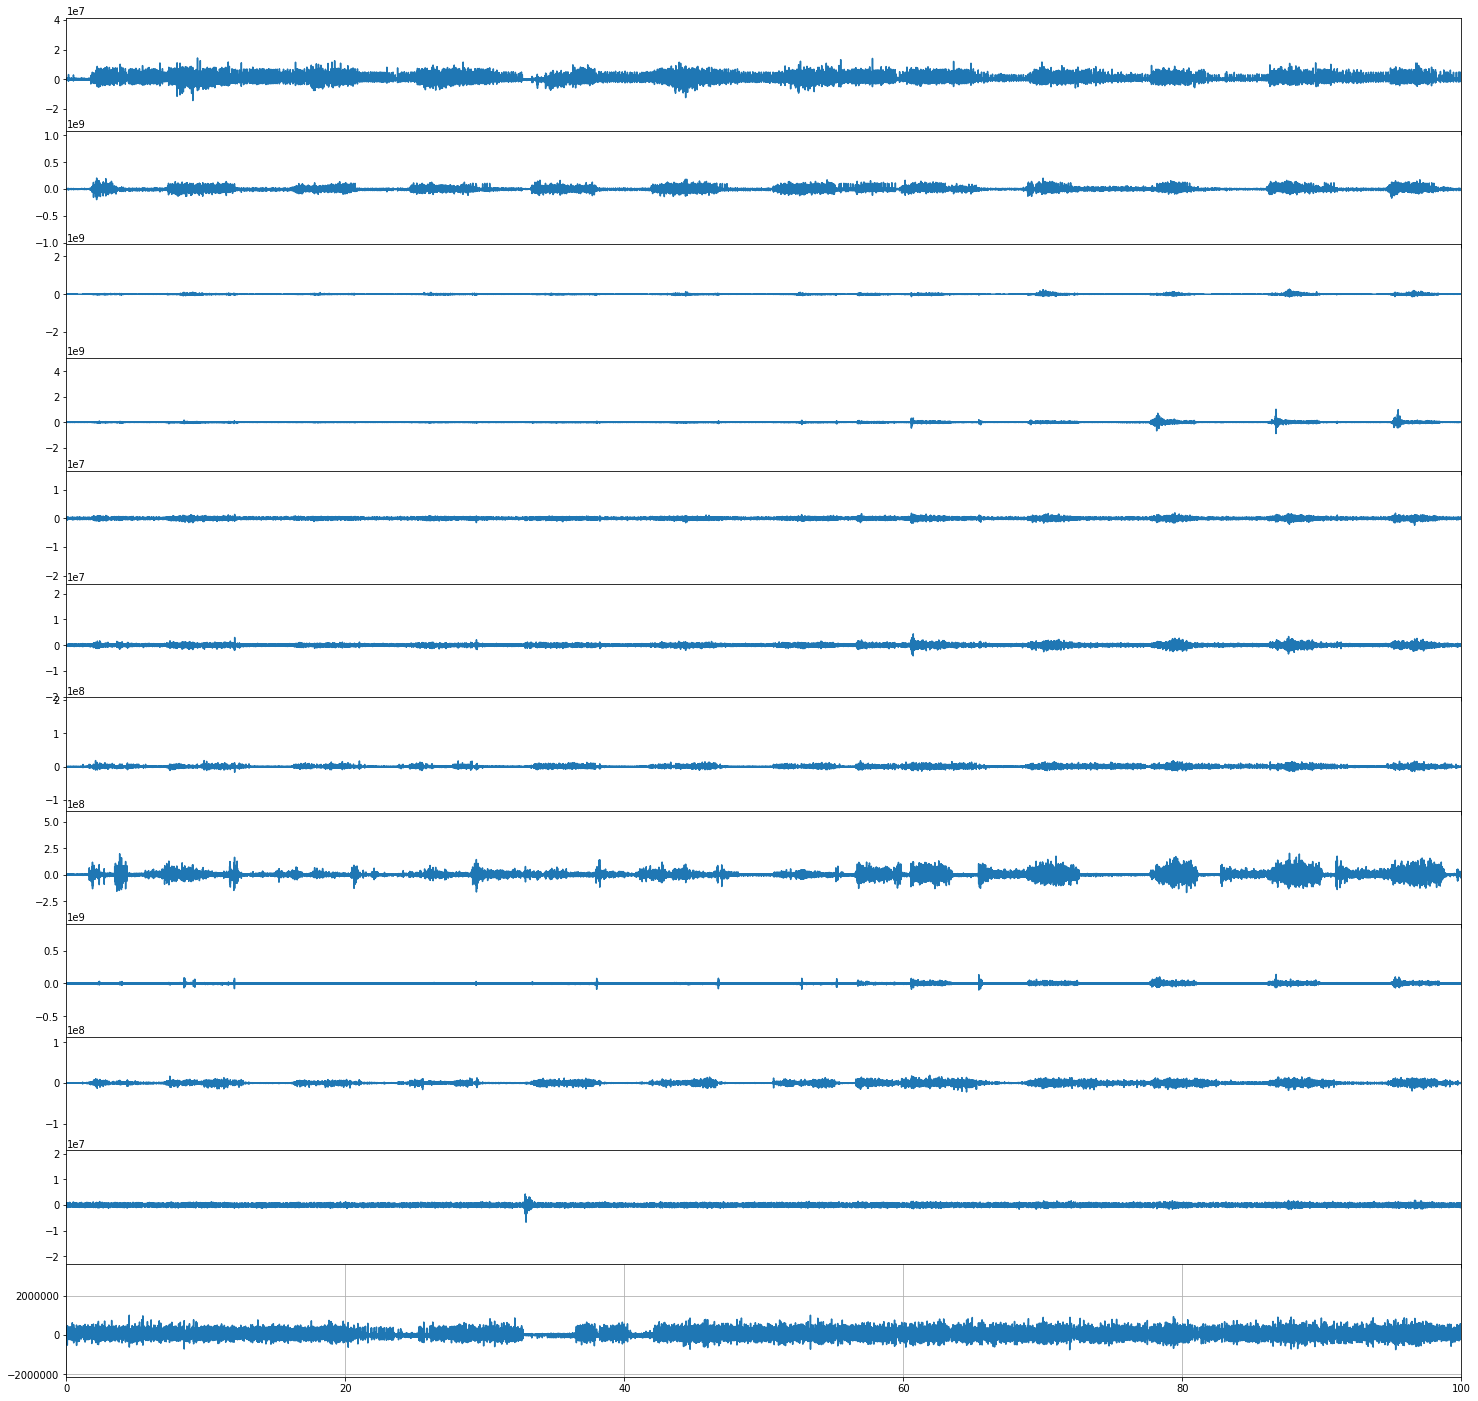

In [8]:
#range for zooming  --> 0 : df.shape[0]/fs
visualization_all_ch(normalized_emg,fs=2000,zooming_from_to=(0,100))
#visualization_one_ch(normalized_emg,ch_num=5,fs=2000,zooming_from_to=(0,20))
#E_df=Env_try (normalized_emg,fs=2000,order=4)
#visualization_all_ch(emg_df)